In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_708228/1321067960.py:20: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'

haiyan_u = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'] for lime in tqdm(range(1,21))],axis=0)
haiyan_v = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['v'] for lime in tqdm(range(1,21))],axis=0)
haiyan_w = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['w'] for lime in tqdm(range(1,21))],axis=0)
haiyan_qv = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['qv'] for lime in tqdm(range(1,21))],axis=0)
haiyan_theta = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['theta'] for lime in tqdm(range(1,21))],axis=0)
haiyan_heatsum = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['heatsum'] for lime in tqdm(range(1,21))],axis=0)
haiyan_hdia = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['hdia'] for lime in tqdm(range(1,21))],axis=0)
haiyan_rad = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['rad'] for lime in tqdm(range(1,21))],axis=0)
haiyan_ir = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['ir'] for lime in tqdm(range(1,21))],axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
def get_d(timeseries=None,divider=None):
    ###################################################################
    def _back_to_exp(timeseries=None,divider=None):
        printout = [timeseries[0:divider[0],:]]
        for i in range(1,19):
            printout.append(timeseries[divider[i-1]:divider[i],:])
        printout.append(timeseries[divider[-2]:,:])
        return printout
    ###################################################################
    left_dot = [forward_diff(obj,60*60,0,1) for obj in _back_to_exp(timeseries,divider)]
    left_dott = np.concatenate([obj for obj in left_dot],axis=0)
    return left_dott
haiyan_du,haiyan_dv,haiyan_dw,haiyan_dtheta = get_d(haiyan_u,divider),get_d(haiyan_v,divider),get_d(haiyan_w,divider),get_d(haiyan_theta,divider)

In [5]:
def get_axisymmetric(var=None,reshapeto=None):
    tempvar = var.reshape(var.shape[0],reshapeto[0],reshapeto[1],reshapeto[2])
    return np.nanmean(tempvar,axis=2).reshape(var.shape[0],-1)
####################################################################
ahaiyan_u = get_axisymmetric(haiyan_u,[10,360,208])
ahaiyan_v = get_axisymmetric(haiyan_v,[10,360,208])
ahaiyan_w = get_axisymmetric(haiyan_w,[10,360,208])
ahaiyan_qv = get_axisymmetric(haiyan_qv,[10,360,208])
ahaiyan_theta = get_axisymmetric(haiyan_theta,[10,360,208])
ahaiyan_heatsum = get_axisymmetric(haiyan_heatsum,[10,360,208])
ahaiyan_hdia = get_axisymmetric(haiyan_hdia,[10,360,208])
ahaiyan_rad = get_axisymmetric(haiyan_rad,[10,360,208])
ahaiyan_ir = get_axisymmetric(haiyan_ir,[10,360,208])
####################################################################
ahaiyan_du = get_axisymmetric(haiyan_du,[10,360,208])
ahaiyan_dv = get_axisymmetric(haiyan_dv,[10,360,208])
ahaiyan_dw = get_axisymmetric(haiyan_dw,[10,360,208])
ahaiyan_dtheta = get_axisymmetric(haiyan_dtheta,[10,360,208])
####################################################################
del haiyan_u,haiyan_v,haiyan_w,haiyan_theta,haiyan_heatsum,haiyan_hdia,haiyan_rad,haiyan_du,haiyan_dv,haiyan_dw,haiyan_dtheta
gc.collect()

118

In [11]:
ahaiyan_dw.shape,ahaiyan_dw.shape

(1545, 2080)

In [12]:
def build_a_xarray_dataset(ds=None,varname=None,varfile=None,dims=None,coords=None):
    def build_xa(arraydata=None,arrayname=None):
        da = xr.DataArray(data=arraydata,dims=dims,coords=coords,name=arrayname)
        return da
    # Complete the code
    for varobj,varnamen in zip(varfile,varname):
        da = build_xa(varobj,varnamen)
        ds = xr.merge( [ds , da ] )
    return ds

dims = ['sample','flatarray']
coords = dict(sample=np.linspace(0,ahaiyan_u.shape[0]-1,ahaiyan_u.shape[0]),flatarray=np.linspace(0,ahaiyan_u.shape[1]-1,ahaiyan_u.shape[1]))
coords2 = dict(sample=np.linspace(0,ahaiyan_du.shape[0]-1,ahaiyan_du.shape[0]),flatarray=np.linspace(0,ahaiyan_du.shape[1]-1,ahaiyan_du.shape[1]))

ds = xr.Dataset(coords=coords)
haiyan_data=build_a_xarray_dataset(ds=ds,varname=['u','v','w','theta','heatsum','hdia','rad','qv','ir'],\
                                   varfile=[ahaiyan_u,ahaiyan_v,ahaiyan_w,ahaiyan_theta,ahaiyan_heatsum,ahaiyan_hdia,ahaiyan_rad,ahaiyan_qv,ahaiyan_ir],dims=dims,coords=coords)
haiyan_data2=build_a_xarray_dataset(ds=ds,varname=['du','dv','dw','dtheta'],\
                                   varfile=[ahaiyan_du,ahaiyan_dv,ahaiyan_dw,ahaiyan_dtheta],dims=dims,coords=coords2)
del ahaiyan_u,ahaiyan_v,ahaiyan_w,ahaiyan_theta,ahaiyan_heatsum,ahaiyan_hdia,ahaiyan_rad,ahaiyan_du,ahaiyan_dv,ahaiyan_dw,ahaiyan_dtheta
gc.collect()

1121

#### Incremental PCA

In [13]:
from sklearn.decomposition import IncrementalPCA
def fit_cheap_pca(n_batches=None,n_comps=None,var=None):
    #n_batches = 20
    inc_pca = IncrementalPCA(n_components=n_comps)
    for X_batch in tqdm(np.array_split(var.data,n_batches)):
        inc_pca.partial_fit(X_batch)
    return inc_pca

In [14]:
pca_store = {}
for varnamex in (['u','v','w','qv','theta','heatsum','hdia','rad','ir']):
    pca_store[varnamex] = fit_cheap_pca(n_batches=10,n_comps=150,var=haiyan_data[varnamex])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/intermediate/'
read_and_proc.save_to_pickle(folderpath+'pca/PCA'+'_'+'dict2_g',pca_store,'PICKLE')
read_and_proc.save_to_pickle(folderpath+'pca/dudvdwdth'+'_'+'dict2_g',haiyan_data2,'PICKLE')
read_and_proc.save_to_pickle(folderpath+'pca/flatvar'+'_'+'dict2_g',haiyan_data,'PICKLE')

In [6]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/intermediate/'
pcastore = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g')
dudvdwdth = read_and_proc.depickle(folderpath+'pca/dudvdwdth'+'_'+'dict2_g')
flatvar = read_and_proc.depickle(folderpath+'pca/flatvar'+'_'+'dict2_g')

In [49]:
[np.abs(pca_store[obj].explained_variance_ratio_.cumsum()-0.91).argmin() for obj in ['u','v','w','qv','theta','heatsum','hdia','rad']]

[8, 0, 10, 9, 3, 6, 6, 4]

/tmp/ipykernel_1484716/1395501283.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


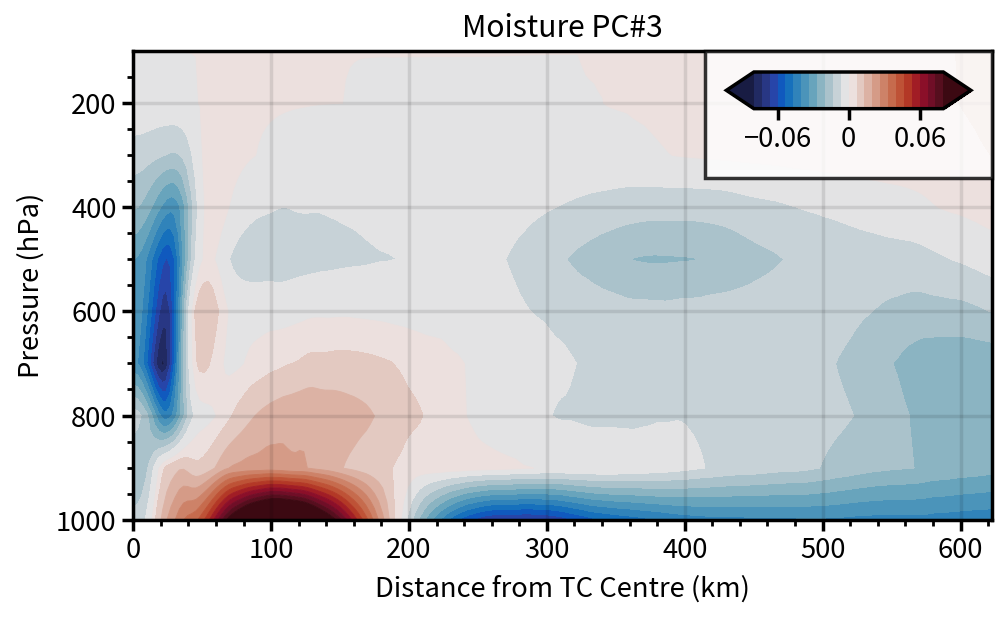

In [36]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs.contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),pcastore['qv'].components_[2,...].reshape(10,208),levels=np.linspace(-0.08,0.08,25),cmap='balance',extend='both')
axs.colorbar(pcw,loc='ur',ticks=0.06)
axs.format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Moisture PC#3')
plt.savefig('../../../figures/0707/intermediate_nonRAD1.png',dpi=300)
plt.show()

/tmp/ipykernel_708228/2642597201.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


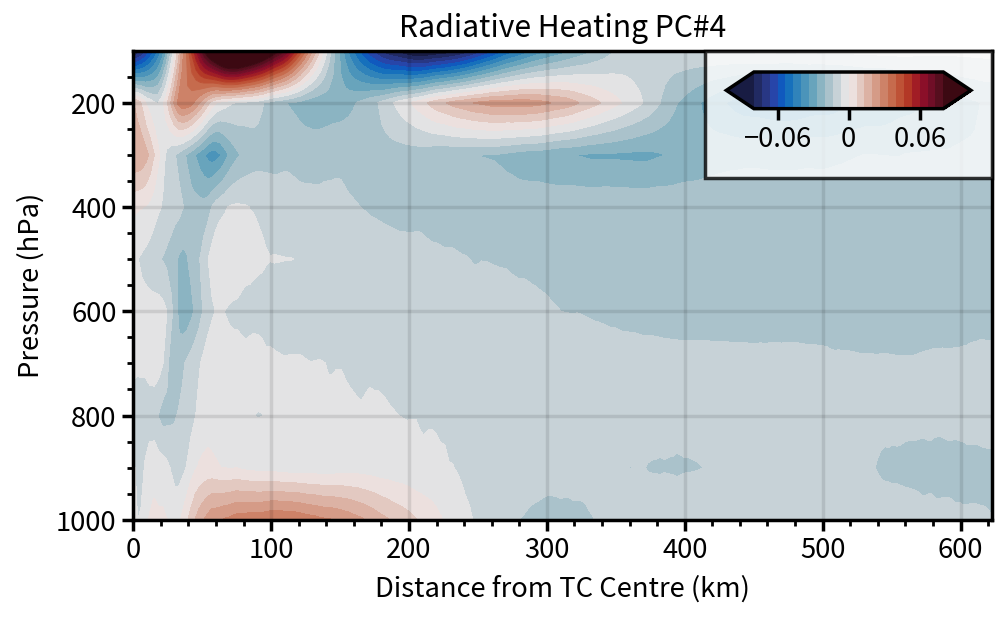

In [12]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs.contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),pcastore['rad'].components_[3,...].reshape(10,208),levels=np.linspace(-0.08,0.08,25),cmap='balance',extend='both')
axs.colorbar(pcw,loc='ur',ticks=0.06)
axs.format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Radiative Heating PC#4')
plt.savefig('../../../figures/0707/intermediate_RAD4.png',dpi=300)
plt.show()

In [ ]:
pca_store['u'].